# Stock Market Volatility Prediction using Sentiment Analysis

# Table of Contents

1. Project Overview
2. Data Collection
3. Data Preprocessing
4. Feature Engineering
    - Technical Indicators
    - Sentiment Features
5. Modeling
    - Baseline Linear Regression
    - Regularized Models (Ridge, Lasso)
    - Tree-Based Models (Random Forest, Gradient Boosting)
    - MLP Regressor
6. Model Evaluation & Validation
    - Time-Based Validation
    - Metric Comparison Table
    - Residual Diagnostics
7. Interpretation & Analysis
    - Feature Importance
    - Model Behavior Analysis
8. Final Report & Next Steps

## Project Overview 
This notebook predicts next-day stock volatility using a combination of:
- **Historical OHLCV stock data** from Yahoo Finance
- **News sentiment analysis** using financial headlines
- **Technical indicators** (RSI, MACD, EMA) for market signals
- **Multiple ML models** to capture different patterns in volatility

**Target Variable**: Daily price volatility percentage = (High - Low) / Open × 100


### Key Imports 

In [7]:
# data imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# date and time handling
from datetime import datetime, timedelta

# stock data import
import yfinance as yf

# visual & plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
color_palette = ['#6A5ACD', '#4169E1', '#1E90FF', '#00BFFF', '#87CEEB']
sns.set_palette(color_palette)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# technical features
from ta.trend import EMAIndicator, MACD
from ta.momentum import RSIIndicator

# sentiment analysis
from textblob import TextBlob

# News API
import requests
from datetime import timedelta
import time

# model interpretation
import shap

# ML imports
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline

from pathlib import Path

### Setup & Configuration

In [14]:
# Stock selection (REPLACE TICKER DETAILS AS REQUIRED) 
STOCK_TICKER = "TSLA" 
PERIOD = "2y" 
INTERVAL = "1d"  

# add your own news_api key
NEWSAPI_KEY = "8f160b733e194588a433aa97baafa4fa"  
COMPANY_NAME = "Tesla" 
NEWS_QUERY = "Tesla OR TSLA"

DATA_DIR = Path("data")
RAW_DATA_DIR = DATA_DIR / "raw"

# Create directories
for dir_path in [DATA_DIR, RAW_DATA_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

### DATA COLLECTION
### Stock Data Collection

In [15]:
print("COLLECTING STOCK DATA")

def collect_stock_data(ticker, period="2y", interval="1d"):
    try:
        print(f"Fetching {ticker} data for period: {period}")
        
        stock = yf.Ticker(ticker)
        df = stock.history(period=period, interval=interval)
        
        df = df.reset_index()
        
        df.columns = [col.replace(' ', '_').lower() for col in df.columns]
        
        df['ticker'] = ticker
        
        print(f"Successfully collected {len(df)} days of data")
        print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
        
        return df
        
    except Exception as e:
        print(f" Error collecting data for {ticker}: {str(e)}")
        return None

df_stock = collect_stock_data(STOCK_TICKER, PERIOD, INTERVAL)

# basic stats for stock data collected
if df_stock is not None:
    print(f"\nStock Data Shape: {df_stock.shape}")
    print(f"Columns: {list(df_stock.columns)}")
    
    # first few rows
    print("\nFirst 5 rows of stock data:")
    print(df_stock.head())
    
    # last few rows
    print("\nLast 5 rows of stock data:")
    print(df_stock.tail())
    
    # stats
    print("\n Stock Price Statistics:")
    print(df_stock[['open', 'high', 'low', 'close', 'volume']].describe())

COLLECTING STOCK DATA
Fetching TSLA data for period: 2y
Successfully collected 500 days of data
Date range: 2023-06-12 to 2025-06-09

Stock Data Shape: (500, 9)
Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits', 'ticker']

First 5 rows of stock data:
                       date        open        high         low       close     volume  dividends  stock_splits ticker
0 2023-06-12 00:00:00-04:00  247.940002  250.970001  244.589996  249.830002  150337900        0.0           0.0   TSLA
1 2023-06-13 00:00:00-04:00  253.509995  259.679993  251.339996  258.709991  162384300        0.0           0.0   TSLA
2 2023-06-14 00:00:00-04:00  260.170013  261.570007  250.500000  256.790009  170575500        0.0           0.0   TSLA
3 2023-06-15 00:00:00-04:00  248.399994  258.950012  247.289993  255.899994  160171200        0.0           0.0   TSLA
4 2023-06-16 00:00:00-04:00  258.920013  263.600006  257.209991  260.540009  167563700        0.0           0.0   TS

### News Data Collection

In [16]:
def collect_news_data(api_key, start_date, end_date, query="AAPL", sleep_time=1):
    print(f"Fetching headlines from {start_date} to {end_date} for query: {query}")

    url = "https://newsapi.org/v2/everything"
    headers = {"Authorization": api_key}

    results = []

    current_date = start_date
    while current_date <= end_date:
        from_str = current_date.strftime('%Y-%m-%d')
        to_str = (current_date + timedelta(days=1)).strftime('%Y-%m-%d')

        params = {
            "q": query,
            "from": from_str,
            "to": to_str,
            "language": "en",
            "sortBy": "relevancy",
            "pageSize": 100,
            "apiKey": api_key
        }

        try:
            response = requests.get(url, params=params)
            data = response.json()
            if "articles" in data:
                headlines = [
                    a.get("title", "") + ". " + (a.get("description") or "")
                    for a in data["articles"]
                ]
                full_text = " ".join(headlines)
                results.append({"date": current_date, "all_headlines": full_text})
                print(f"✅ {from_str} | {len(headlines)} articles")
            else:
                print(f"⚠️ {from_str} | No articles found or error: {data.get('message')}")
                results.append({"date": current_date, "all_headlines": ""})

        except Exception as e:
            print(f"Error on {from_str}: {e}")
            results.append({"date": current_date, "all_headlines": ""})

        time.sleep(sleep_time)
        current_date += timedelta(days=1)

    df_news = pd.DataFrame(results)
    return df_news

In [17]:
today = datetime.today().date()
newsapi_earliest = today - timedelta(days=30)

start_date = max(df_stock['date'].min().date(), newsapi_earliest)
end_date = df_stock['date'].max().date()

print(f"\nNewsAPI Date Range: {start_date} → {end_date} (limited to past 30 days)")
df_news = collect_news_data(NEWSAPI_KEY, start_date, end_date, query=NEWS_QUERY)


NewsAPI Date Range: 2025-05-11 → 2025-06-09 (limited to past 30 days)
Fetching headlines from 2025-05-11 to 2025-06-09 for query: Tesla OR TSLA
✅ 2025-05-11 | 99 articles
✅ 2025-05-12 | 99 articles
✅ 2025-05-13 | 99 articles
✅ 2025-05-14 | 99 articles
✅ 2025-05-15 | 99 articles
✅ 2025-05-16 | 98 articles
✅ 2025-05-17 | 100 articles
✅ 2025-05-18 | 99 articles
✅ 2025-05-19 | 97 articles
✅ 2025-05-20 | 96 articles
✅ 2025-05-21 | 98 articles
✅ 2025-05-22 | 100 articles
✅ 2025-05-23 | 99 articles
✅ 2025-05-24 | 99 articles
✅ 2025-05-25 | 100 articles
✅ 2025-05-26 | 96 articles
✅ 2025-05-27 | 97 articles
✅ 2025-05-28 | 97 articles
✅ 2025-05-29 | 95 articles
✅ 2025-05-30 | 95 articles
✅ 2025-05-31 | 97 articles
✅ 2025-06-01 | 99 articles
✅ 2025-06-02 | 96 articles
✅ 2025-06-03 | 96 articles
✅ 2025-06-04 | 98 articles
✅ 2025-06-05 | 100 articles
✅ 2025-06-06 | 100 articles
✅ 2025-06-07 | 98 articles
✅ 2025-06-08 | 99 articles
✅ 2025-06-09 | 58 articles


In [18]:
# Clean news data
df_news['all_headlines'] = df_news['all_headlines'].astype(str)
df_news['all_headlines'] = df_news['all_headlines'].str.lower()
df_news['all_headlines'] = df_news['all_headlines'].str.replace(r'[^\w\s]', '', regex=True)
df_news['all_headlines'] = df_news['all_headlines'].str.replace(r'\s+', ' ', regex=True).str.strip()
# remove duplicates
df_news = df_news.drop_duplicates('all_headlines')
# preview
print(df_news[['date', 'all_headlines']])

          date                                      all_headlines
0   2025-05-11  the longestrange tesla will do 402 miles but t...
1   2025-05-12  elon musk says he wants to bring teslas robota...
2   2025-05-13  elon musk says he wants to bring teslas robota...
3   2025-05-14  tesla required leased cars be returned for rob...
4   2025-05-15  tesla required leased cars be returned for rob...
5   2025-05-16  is elon musk really stepping back from doge el...
6   2025-05-17  is elon musk really stepping back from doge el...
7   2025-05-18  polestar 4 2025 review prices specs availabili...
8   2025-05-19  elon musk says theres no need for tesla to buy...
9   2025-05-20  elon musk says he isnt ruling out merging xai ...
10  2025-05-21  xiaomis new pu7 spells trouble for tesla in ch...
11  2025-05-22  xiaomis new pu7 spells trouble for tesla in ch...
12  2025-05-23  xiaomis new yu7 spells trouble for tesla in ch...
13  2025-05-24  elon musk says hes getting back to business at...
14  2025-0

### Data Preprocessing & Feature Engineering

In [22]:

# Preprocessing

# normalize dates
df_stock['date'] = pd.to_datetime(df_stock['date']).dt.tz_localize(None).dt.normalize()
df_news['date'] = pd.to_datetime(df_news['date']).dt.normalize()
df_merged = pd.merge(df_stock, df_news, on="date", how="left")

# handle missing headlines (limited 30 day limit)
df_merged['all_headlines'] = df_merged['all_headlines'].fillna("")


# Feature Engineering

# EMA (Exponential Moving Average)
ema_10 = EMAIndicator(close=df_merged['close'], window=10)
df_merged['ema_10'] = ema_10.ema_indicator()

# MACD (Moving Average Convergence Divergence)
macd = MACD(close=df_merged['close'])
df_merged['macd'] = macd.macd()
df_merged['macd_signal'] = macd.macd_signal()

# RSI (Relative Strength Index)
rsi = RSIIndicator(close=df_merged['close'], window=14)
df_merged['rsi'] = rsi.rsi()

# Volatility % (Target)
df_merged['daily_range'] = df_merged['high'] - df_merged['low']
df_merged['volatility_pct'] = (df_merged['daily_range'] / df_merged['open']) * 100

# Lagged features
df_merged['rsi_lag1'] = df_merged['rsi'].shift(1)
df_merged['volatility_pct_lag1'] = df_merged['volatility_pct'].shift(1)
 

# preview
print("\n Enriched dataset preview:")
print(df_merged[['date', 'close', 'ema_10', 'macd', 'rsi', 'volatility_pct', 'all_headlines']].tail(5))



 Enriched dataset preview:
          date       close      ema_10       macd        rsi  volatility_pct                                      all_headlines
495 2025-06-03  344.269989  344.388716  17.915228  59.945931        3.566066  elon musk slammed trumps big beautiful bill th...
496 2025-06-04  332.049988  342.145311  15.782451  53.750574        5.294123  elon musk slammed trumps big beautiful bill th...
497 2025-06-05  284.700012  331.700711  10.154409  37.554706       15.919873  the cadillac optiqv is gms first ev with built...
498 2025-06-06  295.140015  325.053312   6.462075  41.724124        4.805403  the cadillac optiqv is gms first ev with built...
499 2025-06-09  308.579987  322.058162   4.567714  46.661529        9.784579  cathie wood says tesla is the stock shed pick ...


### Sentiment Analysis Score based on News Headlines

In [25]:
from textblob import TextBlob

# scoring function
def get_textblob_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0
    return TextBlob(text).sentiment.polarity

df_merged['sentiment_score'] = df_merged['all_headlines'].apply(get_textblob_sentiment)

# preview
print("\nFinal dataset preview with sentiment:")
print(df_merged[['date', 'close', 'volatility_pct', 'sentiment_score', 'all_headlines']].tail(5))



Final dataset preview with sentiment:
          date       close  volatility_pct  sentiment_score                                      all_headlines
495 2025-06-03  344.269989        3.566066         0.091876  elon musk slammed trumps big beautiful bill th...
496 2025-06-04  332.049988        5.294123         0.077374  elon musk slammed trumps big beautiful bill th...
497 2025-06-05  284.700012       15.919873         0.035013  the cadillac optiqv is gms first ev with built...
498 2025-06-06  295.140015        4.805403         0.061622  the cadillac optiqv is gms first ev with built...
499 2025-06-09  308.579987        9.784579         0.034629  cathie wood says tesla is the stock shed pick ...


In [27]:
# save processed data 
df_merged.to_csv("processed_stock_data.csv", index=False)

## Exploratory Data Analysis 

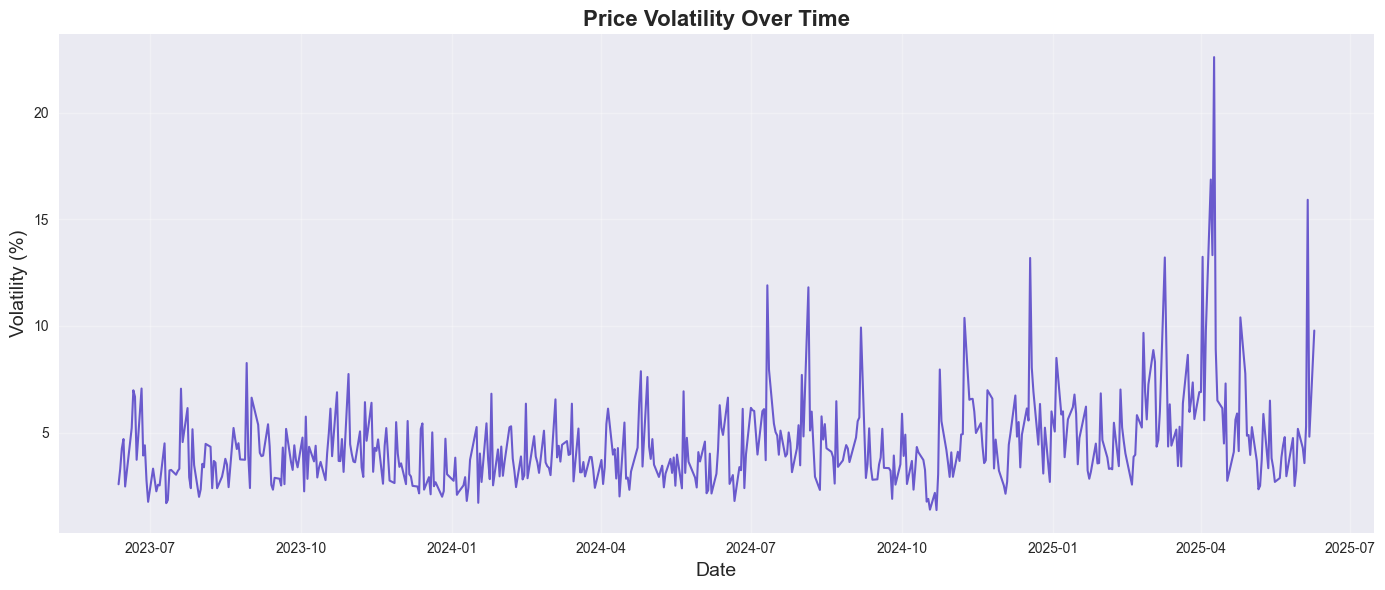

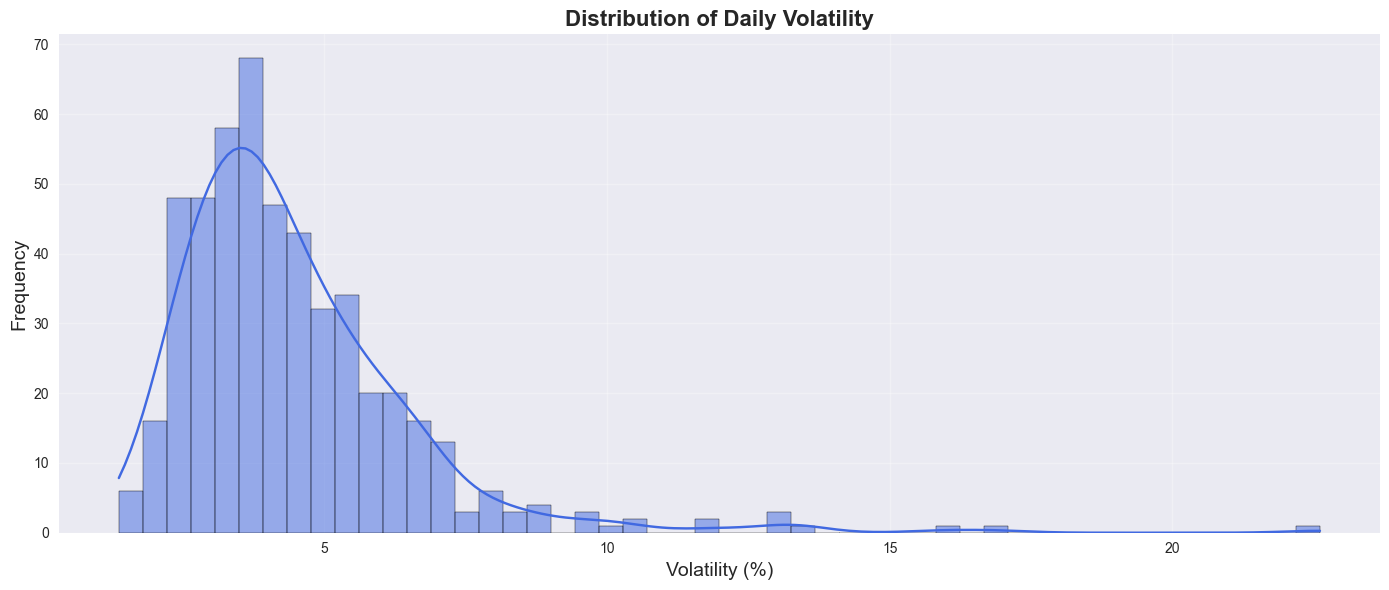

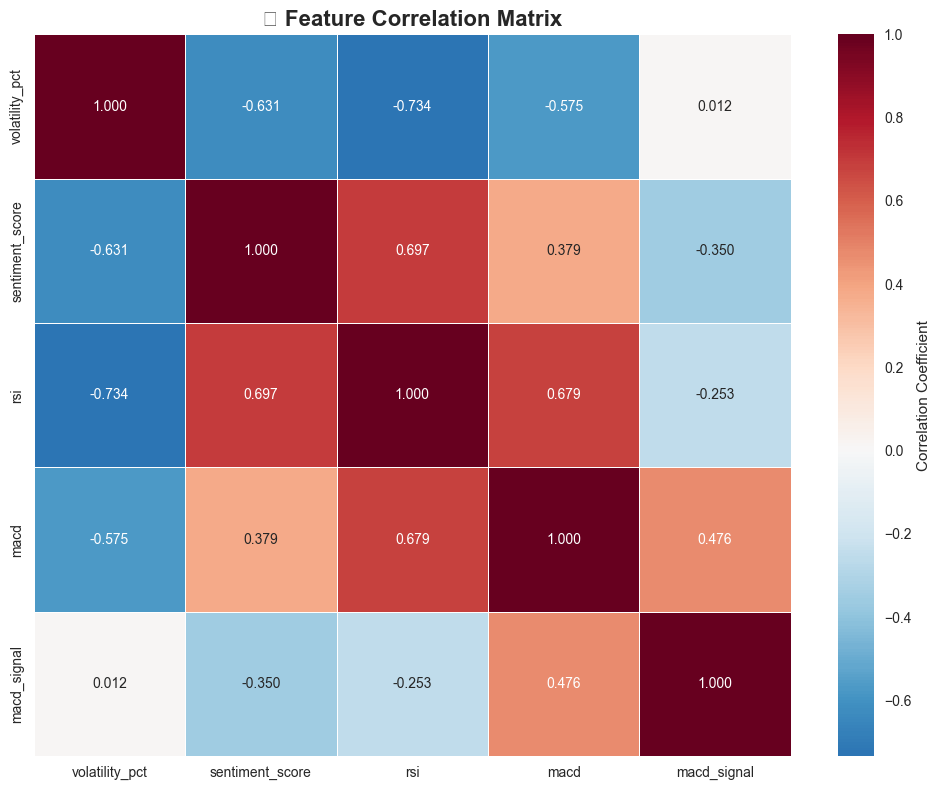

📊 Key Correlations with Volatility:
  rsi: -0.734
  sentiment_score: -0.631
  macd: -0.575
  macd_signal: 0.012


In [38]:
plt.figure(figsize=(14, 6))
plt.plot(df_merged['date'], df_merged['volatility_pct'], color=color_palette[0], linewidth=1.5)
plt.title('Price Volatility Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volatility (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.histplot(df_merged['volatility_pct'], bins=50, kde=True, color=color_palette[1])
plt.title('Distribution of Daily Volatility', fontsize=16, fontweight='bold')
plt.xlabel('Volatility (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

correlation_features = ['volatility_pct', 'sentiment_score', 'rsi', 'macd', 'macd_signal']
df_corr = df_merged[df_merged['sentiment_score'] != 0.0][correlation_features].dropna()
corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".3f", 
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('🔗 Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("📊 Key Correlations with Volatility:")
vol_corr = corr_matrix['volatility_pct'].drop('volatility_pct').sort_values(key=abs, ascending=False)
for feature, corr in vol_corr.items():
    print(f"  {feature}: {corr:.3f}")


Baseline check - phase 1

In [95]:
print(df_merged.columns)

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits', 'ticker', 'all_headlines', 'sentiment_score', 'ema_10', 'macd', 'macd_signal', 'rsi', 'daily_range', 'volatility_pct', 'rsi_lag1'], dtype='object')


📉 Linear Regression Baseline with Lagged Volatility:
RMSE: 0.3485
MAE: 0.1351
R² Score: 0.9791


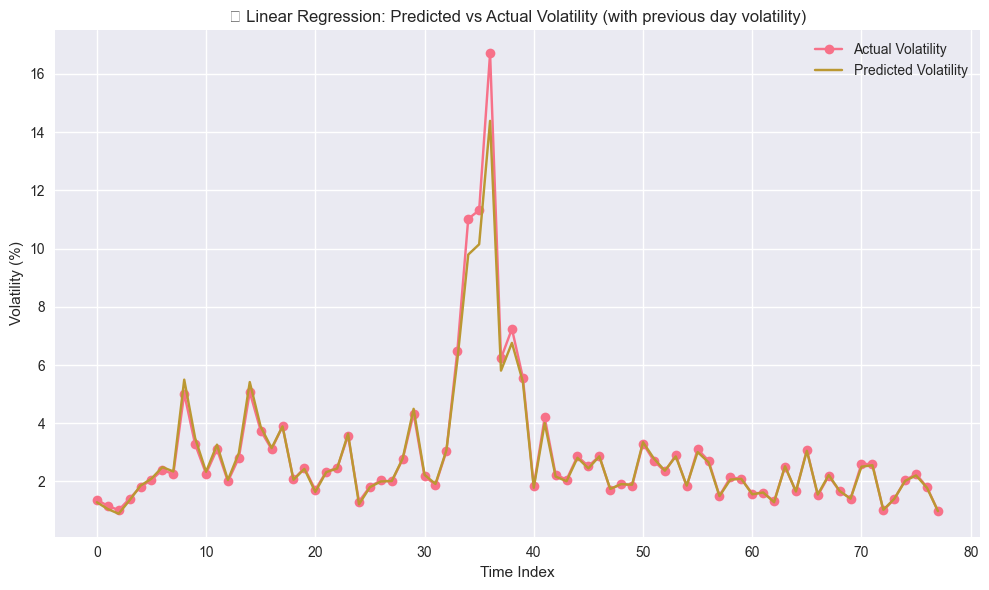

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Create lagged volatility feature ---
df_merged['volatility_pct_lag1'] = df_merged['volatility_pct'].shift(1)


# --- Define your modeling DataFrame with lagged volatility included ---
df_model = df_merged[[
    'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
    'sentiment_score', 'ema_10', 'macd', 'macd_signal', 'rsi', 'daily_range',
    'volatility_pct',  # target
    'rsi_lag1', 
    'rsi_signal',
    'volatility_pct_lag1'  # new lag feature
]].dropna()

# --- Define features and target ---
# Exclude 'volatility_pct' (target) from features
features = [
    'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
    'sentiment_score', 'ema_10', 'macd', 'macd_signal', 'rsi', 'daily_range',
    'rsi_lag1', 
    'rsi_signal',
    'volatility_pct_lag1'  # include previous day volatility
]

X = df_model[features]
y = df_model['volatility_pct']

# --- TimeSeriesSplit for train/test ---
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = list(tscv.split(X))[-1]

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# --- Fit Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)

# --- Predict and evaluate ---
y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📉 Linear Regression Baseline with Lagged Volatility:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Plot Predicted vs Actual ---
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Volatility', marker='o')
plt.plot(y_pred, label='Predicted Volatility', marker='x')
plt.title('📊 Linear Regression: Predicted vs Actual Volatility')
plt.xlabel('Time Index')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [123]:
# Get coefficients and feature names
coef = lr.coef_
features = X.columns

# Create DataFrame for easier viewing
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef,
    'AbsCoefficient': np.abs(coef)
})

# Sort by absolute coefficient value descending
coef_df_sorted = coef_df.sort_values(by='AbsCoefficient', ascending=False).reset_index(drop=True)

print("📋 Linear Regression Feature Coefficients (sorted by importance):")
print(coef_df_sorted[['Feature', 'Coefficient']])


📋 Linear Regression Feature Coefficients (sorted by importance):
                Feature   Coefficient
0           daily_range  3.203773e-01
1                  high  1.645570e-01
2                   low -1.558202e-01
3             dividends  2.892386e-02
4                  open -2.766248e-02
5                  macd  2.249406e-02
6           macd_signal -1.697801e-02
7                 close  6.699150e-03
8                ema_10  3.810706e-03
9                   rsi -3.260246e-03
10  volatility_pct_lag1  2.211450e-03
11             rsi_lag1  2.132143e-03
12           rsi_signal  4.861124e-04
13               volume  1.594828e-10
14      sentiment_score -5.551115e-17
15         stock_splits -4.770490e-18



📊 Random Forest
📉 RMSE: 1.2306
📉 MAE: 0.3679
📈 R² Score: 0.7394


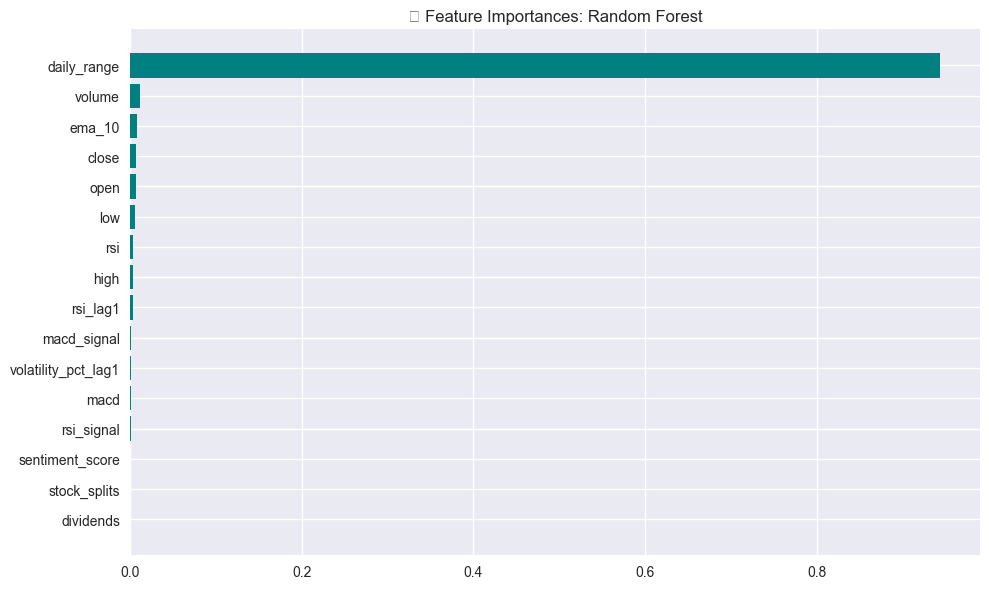

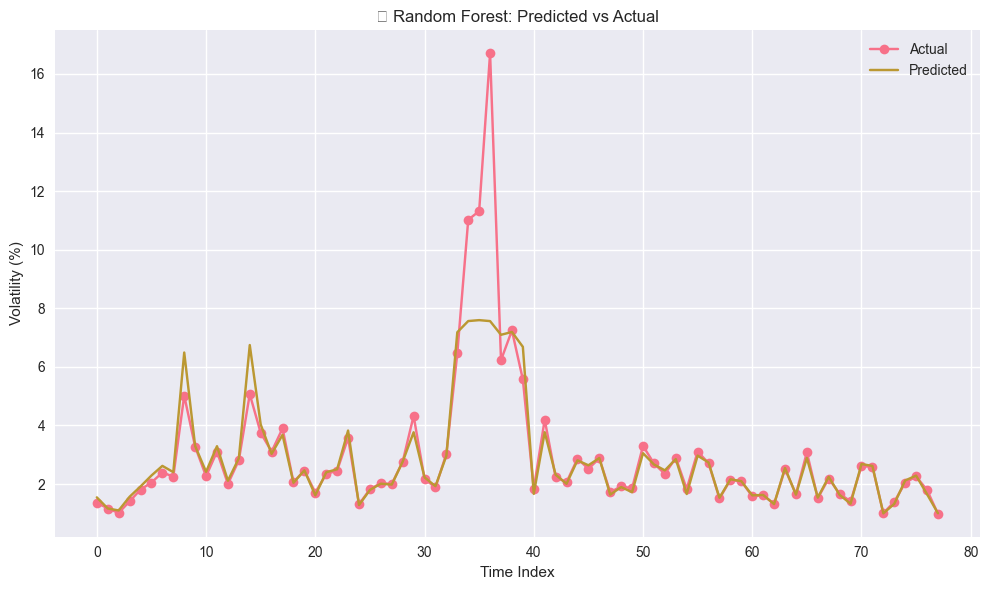

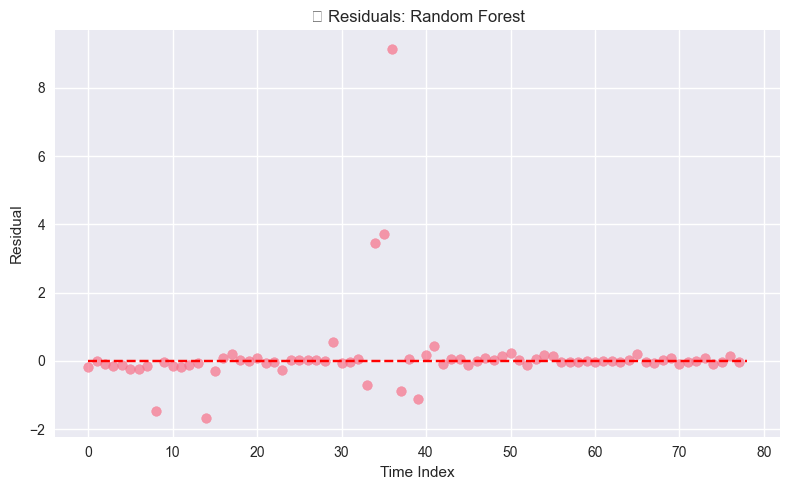

In [125]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV


# --- Random Forest Regressor ---
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test)


# --- Evaluation Function ---
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {name}")
    print(f"📉 RMSE: {rmse:.4f}")
    print(f"📉 MAE: {mae:.4f}")
    print(f"📈 R² Score: {r2:.4f}")
    return rmse, mae, r2

# --- Evaluate Both Models ---
evaluate_model("Random Forest", y_test, y_rf_pred)

# --- Feature Importances Plot ---
def plot_feature_importance(model, model_name):
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(features)[sorted_idx], importances[sorted_idx], color='teal')
    plt.title(f"🔍 Feature Importances: {model_name}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf, "Random Forest")

# --- Predicted vs Actual ---
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true.values, label='Actual', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title(title)
    plt.xlabel('Time Index')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predictions(y_test, y_rf_pred, "📈 Random Forest: Predicted vs Actual")

# --- Residual Plot ---
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    plt.scatter(range(len(residuals)), residuals, alpha=0.7)
    plt.hlines(0, 0, len(residuals), colors='red', linestyles='dashed')
    plt.title(title)
    plt.xlabel('Time Index')
    plt.ylabel('Residual')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, y_rf_pred, "📉 Residuals: Random Forest")



📊 Tuned Gradient Boosting
📉 RMSE: 1.0114
📉 MAE: 0.2631
📈 R² Score: 0.8240


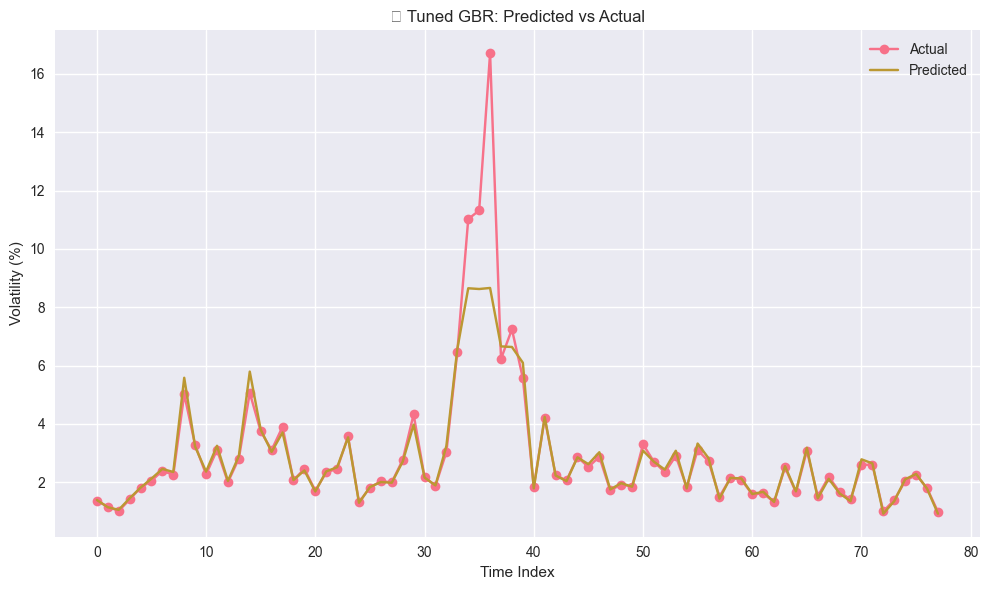

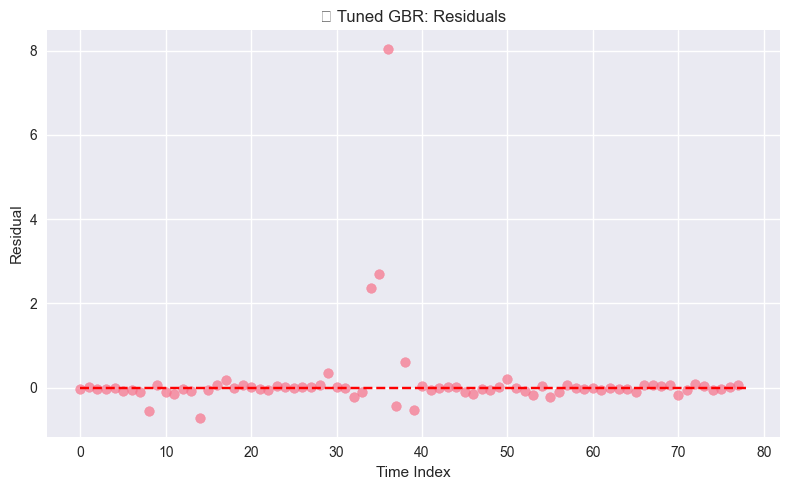

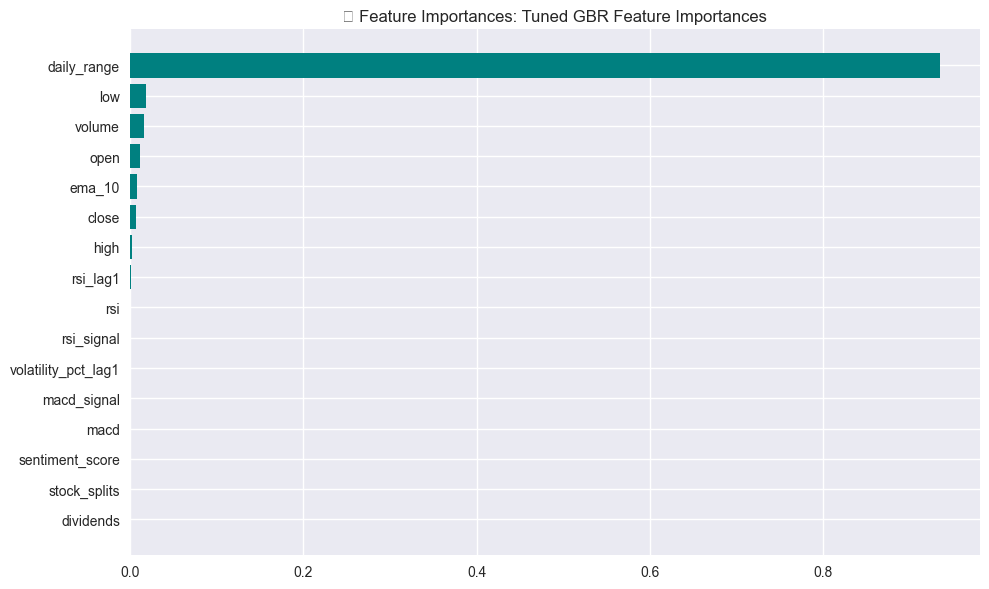

In [129]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    learning_rate=0.01,         # slower, more precise learning
    n_estimators=1000,          # more boosting rounds
    max_depth=3,                # lower to prevent overfitting
    min_samples_split=5,        # more conservative splits
    subsample=0.8,              # random sampling for robustness
    random_state=42
)

gbr.fit(X_train, y_train)
y_gbr_pred = gbr.predict(X_test)

evaluate_model("Tuned Gradient Boosting", y_test, y_gbr_pred)
plot_predictions(y_test, y_gbr_pred, "📈 Tuned GBR: Predicted vs Actual")
plot_residuals(y_test, y_gbr_pred, "📉 Tuned GBR: Residuals")
plot_feature_importance(gbr, "Tuned GBR Feature Importances")


🧠 MLP Regressor (Standardized) Results:
📉 RMSE: 0.2410
📉 MAE: 0.1162
📈 R² Score: 0.9900


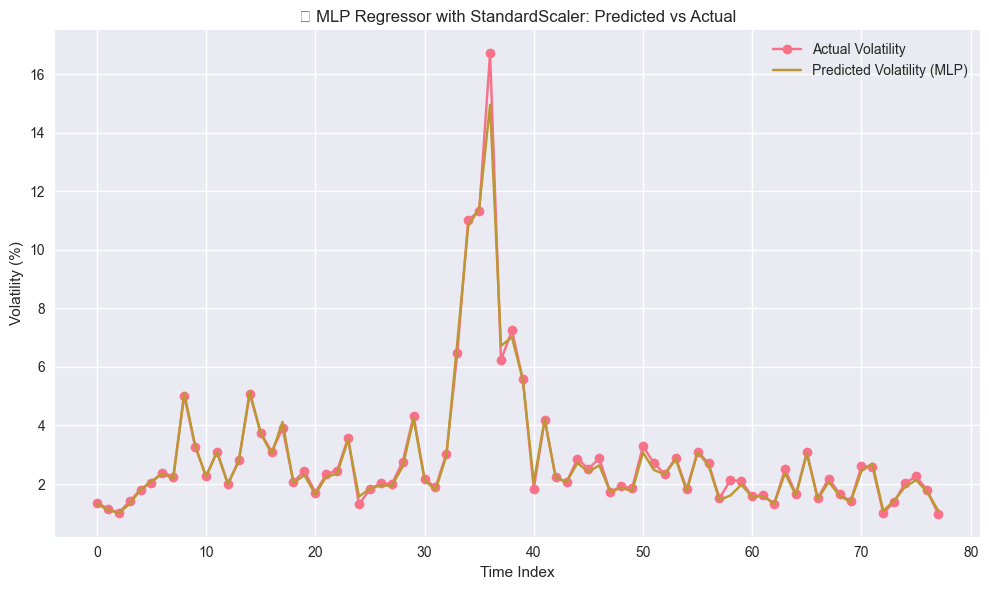

In [142]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np

# --- Features and Target ---
features = [
    'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
    'sentiment_score', 'ema_10', 'macd', 'macd_signal', 'rsi', 'daily_range',
    'rsi_lag1', 'rsi_signal', 'volatility_pct_lag1'
]
X = df_model[features]
y = df_model['volatility_pct']

# --- TimeSeries Split ---
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = list(tscv.split(X))[-1]
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# --- Standardize Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- MLP Regressor ---
mlp = MLPRegressor(hidden_layer_sizes=(64,64,64),
                   activation='relu',
                   solver='adam',
                   max_iter=1000,
                   early_stopping=True,
                   random_state=42)

mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("🧠 MLP Regressor (Standardized) Results:")
print(f"📉 RMSE: {rmse:.4f}")
print(f"📉 MAE: {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")

# --- Plot Predicted vs Actual ---
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Volatility', marker='o')
plt.plot(y_pred, label='Predicted Volatility (MLP)', marker='x')
plt.title('🧠 MLP Regressor with StandardScaler: Predicted vs Actual')
plt.xlabel('Time Index')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1
  RMSE: 0.3585
  MAE: 0.2378
  R²: 0.5720

Fold 2
  RMSE: 0.3172
  MAE: 0.2075
  R²: 0.9101

Fold 3
  RMSE: 0.4735
  MAE: 0.4565
  R²: 0.7988

Fold 4
  RMSE: 0.2240
  MAE: 0.1714
  R²: 0.9335

Fold 5
  RMSE: 0.2580
  MAE: 0.1429
  R²: 0.9886

=== Cross-Validation Summary ===
Average RMSE: 0.3262 ± 0.0871
Average MAE: 0.2432 ± 0.1114
Average R²: 0.8406 ± 0.1478


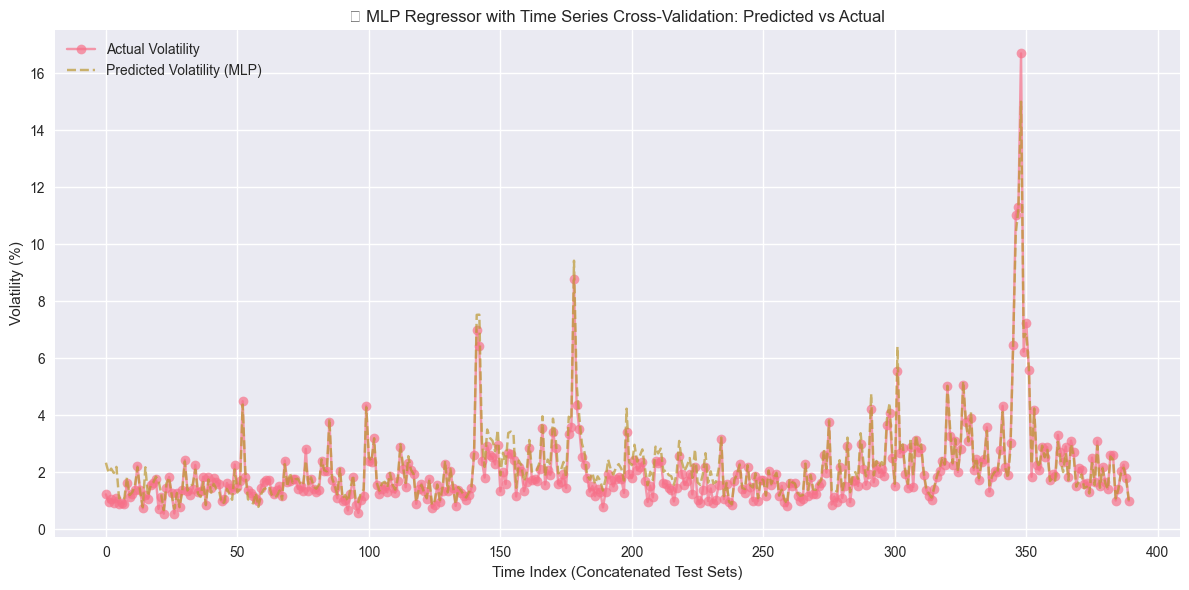

In [153]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Features and Target ---
features = [
    'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
    'sentiment_score', 'ema_10', 'macd', 'macd_signal', 'rsi', 'daily_range',
    'rsi_lag1', 'rsi_signal', 'volatility_pct_lag1'
]
X = df_model[features]
y = df_model['volatility_pct']

# --- TimeSeries Split ---
tscv = TimeSeriesSplit(n_splits=5)

# To store metrics for each fold
rmse_scores = []
mae_scores = []
r2_scores = []

# To store predictions and actual values (optional)
all_preds = []
all_actuals = []

fold_num = 1
for train_index, test_index in tscv.split(X):
    print(f"Fold {fold_num}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # --- Standardize Features ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- MLP Regressor ---
    # mlp = MLPRegressor(hidden_layer_sizes=(256,128,64),
    #                    activation='relu',
    #                    solver='adam',
    #                    max_iter=1000,
    #                    early_stopping=True,
    #                    random_state=42)
    mlp = MLPRegressor(
        hidden_layer_sizes=(256,128,64),
        activation='relu',
        solver='adam',
        alpha=0.002,
        learning_rate_init=0.001,
        max_iter=1000,
        early_stopping=True,
        random_state=42
    )
    
    mlp.fit(X_train_scaled, y_train)
    y_pred = mlp.predict(X_test_scaled)

    # --- Evaluation ---
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}\n")

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    all_preds.extend(y_pred)
    all_actuals.extend(y_test)

    fold_num += 1

# --- Summary ---
print("=== Cross-Validation Summary ===")
print(f"Average RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Average R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

# --- Plot All Folds Combined ---
plt.figure(figsize=(12,6))
plt.plot(all_actuals, label='Actual Volatility', marker='o', linestyle='-', alpha=0.7)
plt.plot(all_preds, label='Predicted Volatility (MLP)', marker='x', linestyle='--', alpha=0.7)
plt.title('🧠 MLP Regressor with Time Series Cross-Validation: Predicted vs Actual')
plt.xlabel('Time Index (Concatenated Test Sets)')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fold 1 Results:
📉 RMSE: 0.0258
📉 MAE: 0.0180
📈 R² Score: 0.9978
------------------------------
Fold 2 Results:
📉 RMSE: 0.0984
📉 MAE: 0.0522
📈 R² Score: 0.9913
------------------------------
Fold 3 Results:
📉 RMSE: 0.1632
📉 MAE: 0.1217
📈 R² Score: 0.9761
------------------------------
Fold 4 Results:
📉 RMSE: 0.2006
📉 MAE: 0.1334
📈 R² Score: 0.9467
------------------------------
Fold 5 Results:
📉 RMSE: 0.3485
📉 MAE: 0.1351
📈 R² Score: 0.9791
------------------------------

=== Cross-Validation Summary ===
Average RMSE: 0.1673 ± 0.1084
Average MAE: 0.0921 ± 0.0480
Average R²: 0.9782 ± 0.0176


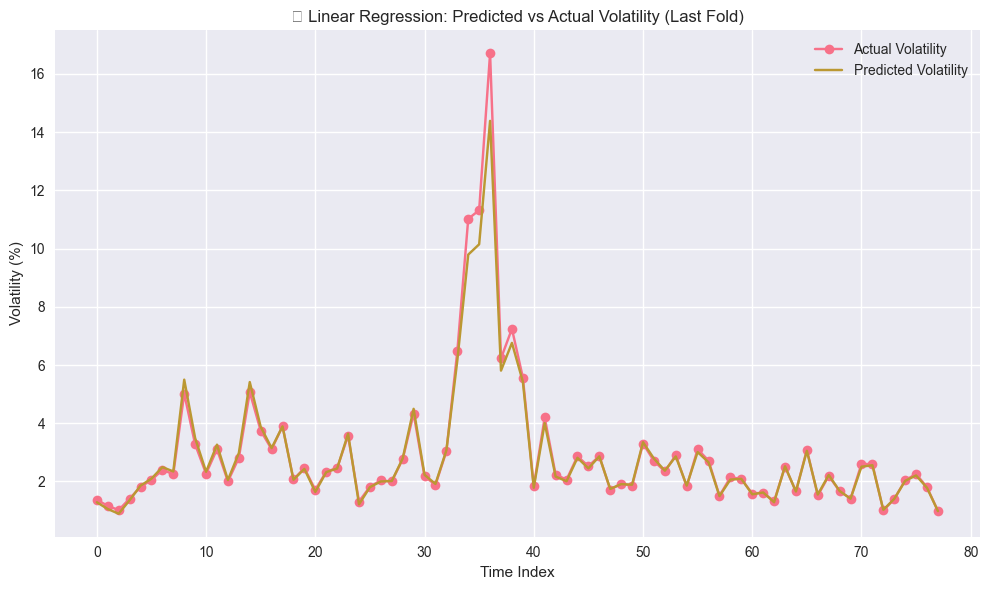

In [154]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_model is already prepared as you described

features = [
    'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
    'sentiment_score', 'ema_10', 'macd', 'macd_signal', 'rsi', 'daily_range',
    'rsi_lag1', 
    'rsi_signal',
    'volatility_pct_lag1'  # include previous day volatility
]

X = df_model[features]
y = df_model['volatility_pct']

tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
mae_scores = []
r2_scores = []

for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Fold {fold} Results:")
    print(f"📉 RMSE: {rmse:.4f}")
    print(f"📉 MAE: {mae:.4f}")
    print(f"📈 R² Score: {r2:.4f}")
    print('-'*30)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

print("\n=== Cross-Validation Summary ===")
print(f"Average RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Average R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

# Optional: plot predicted vs actual for the last fold
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Volatility', marker='o')
plt.plot(y_pred, label='Predicted Volatility', marker='x')
plt.title('📊 Linear Regression: Predicted vs Actual Volatility (Last Fold)')
plt.xlabel('Time Index')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


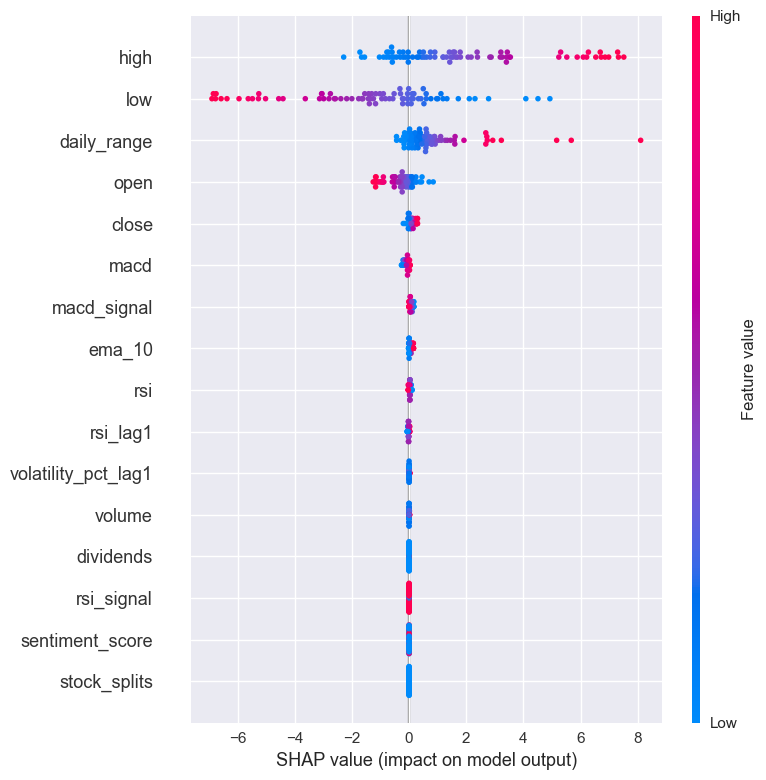

In [159]:
import shap

# Use last training set (X_train) from TimeSeriesSplit
explainer = shap.Explainer(lr, X_train)
shap_values = explainer(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)



📘 RidgeCV
Best alpha: 5.72237
RMSE: 0.0198
R² Score: 0.9890

📙 LassoCV
Best alpha: 0.00100
RMSE: 0.0176
R² Score: 0.9903


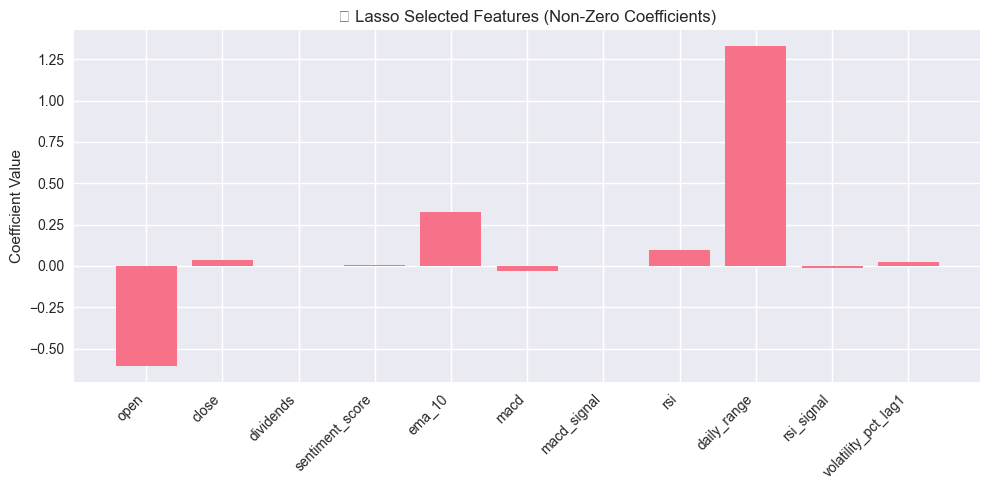

In [164]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

X = df_model[features]
y = df_model['volatility_pct']

# --- Step 1: Ridge Regression ---
ridge_alphas = np.logspace(-3, 3, 100)
ridge_model = make_pipeline(StandardScaler(), RidgeCV(alphas=ridge_alphas, cv=5))
ridge_model.fit(X, y)

# Predictions & Metrics
ridge_preds = ridge_model.predict(X)
ridge_rmse = mean_squared_error(y, ridge_preds)
ridge_r2 = r2_score(y, ridge_preds)

print("📘 RidgeCV")
print(f"Best alpha: {ridge_model.named_steps['ridgecv'].alpha_:.5f}")
print(f"RMSE: {ridge_rmse:.4f}")
print(f"R² Score: {ridge_r2:.4f}")

# --- Step 2: Lasso Regression (with Feature Selection) ---
lasso_alphas = np.logspace(-3, 3, 100)
lasso_model = make_pipeline(StandardScaler(), LassoCV(alphas=lasso_alphas, cv=5, max_iter=5000))
lasso_model.fit(X, y)

lasso_preds = lasso_model.predict(X)
lasso_rmse = mean_squared_error(y, lasso_preds)
lasso_r2 = r2_score(y, lasso_preds)

print("\n📙 LassoCV")
print(f"Best alpha: {lasso_model.named_steps['lassocv'].alpha_:.5f}")
print(f"RMSE: {lasso_rmse:.4f}")
print(f"R² Score: {lasso_r2:.4f}")

# --- Step 3: Coefficient Analysis ---
# Extract feature names and corresponding coefficients
lasso_coefs = lasso_model.named_steps['lassocv'].coef_
features_selected = X.columns[lasso_coefs != 0]

# Plot non-zero coefficients
plt.figure(figsize=(10, 5))
plt.bar(features_selected, lasso_coefs[lasso_coefs != 0])
plt.xticks(rotation=45, ha='right')
plt.title("📊 Lasso Selected Features (Non-Zero Coefficients)")
plt.ylabel("Coefficient Value")
plt.tight_layout()
plt.show()


In [168]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# --- Parameters ---
n_splits = 5  # You can increase for finer validation

# --- Prepare split ---
tscv = TimeSeriesSplit(n_splits=n_splits)
lasso_rmse_scores = []
lasso_r2_scores = []

fold = 1
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Re-initialize the model in each fold (important!)
    lasso = make_pipeline(StandardScaler(), LassoCV(alphas=np.logspace(-3, 3, 100), cv=5, max_iter=5000))
    lasso.fit(X_train, y_train)

    y_pred = lasso.predict(X_test)

    # Metrics
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    lasso_rmse_scores.append(rmse)
    lasso_r2_scores.append(r2)

    print(f"📅 Fold {fold}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")
    fold += 1

# --- Summary Metrics ---
print("\n📊 Walk-Forward Validation Summary (LassoCV)")
print(f"Avg RMSE: {np.mean(lasso_rmse_scores):.4f} ± {np.std(lasso_rmse_scores):.4f}")
print(f"Avg R²: {np.mean(lasso_r2_scores):.4f} ± {np.std(lasso_r2_scores):.4f}")


📅 Fold 1
  RMSE: 0.0005
  R²: 0.9984
📅 Fold 2
  RMSE: 0.0138
  R²: 0.9877
📅 Fold 3
  RMSE: 0.0137
  R²: 0.9877
📅 Fold 4
  RMSE: 0.0340
  R²: 0.9549
📅 Fold 5
  RMSE: 0.1448
  R²: 0.9751

📊 Walk-Forward Validation Summary (LassoCV)
Avg RMSE: 0.0414 ± 0.0528
Avg R²: 0.9808 ± 0.0149
